# OPTIMIZE MARKETING EXPENSES

# Introduction <a id='intro'></a>

- Utilizing server logs, order data, and marketing expenditure records, this project investigates user behavior on Y.Afisha.
- The analysis focuses on understanding product usage patterns, purchase initiation timing, and customer spending trends.
- By extracting insights on payment timelines and customer spending habits, the project aims to inform marketing optimization strategies and enhance user engagement.
- This project will test the data wrangling skills, business analysis acumen, research skill, visualization and presentation skills.

> visits table (server logs with data on website visits):
> - Uid — user's unique identifier
> - Device — user's device
> - Start Ts — session start date and time
> - End Ts — session end date and time
> - Source Id — identifier of the ad source the user came from
> - All dates in this table are in YYYY-MM-DD format.


> orders table (data on orders)::
> - Uid — unique identifier of the user making an order
> - Buy Ts — order date and time
> - Revenue — Y.Afisha's revenue from the order

> costs table (data on marketing expenses):
> -source_id — ad source identifier
> - dt — date
> - costs — expenses on this ad source on this day

## Goals:

- To understand how people use the product
- To identify when does the people start to buy
- To identify how much money each customer brings in
- To optimize marketing expenses

 # Table of Contents  
1. [Stage 1: Data Preprocessing](#1)
    1. ['visits' file](#2)
    1. ['orders' file](#3) 
    1. ['costs' file](#4) 
1. [Stage 2: Exploratory Data Analysis](#5) 
    1. [Product](#6)
       1. [Day, Week, and Month Traffic](#7)
       1. [Number of Session](#8)
       1. [Length of each session](#9)
       1. [The user retention rate](#10)
    1. [Sales](#11)
       1. [Duration of people start buying](#12)
       1. [Number of orders made during a given period of time](#13)
       1. [Average purchase size](#14)
       1. [Amount of money received (LTV-customer's lifetime value)](#15)
    1. [Marketing](#16)
       1. [Amount of money spent (Overall/per source/over time)](#17)
       1. [Amount of customer acquisition from each of the sources cost](#18)
       1. [How worthwhile where the investments? (ROI)](#19)
1. [Stage 3: General Conclusion](#20)

<a id="1"></a> 
# Stage 1 : Data Preprocessing

In [1]:
!pip install missingno

In [2]:
from scipy import stats as st #for probability and calculation of statistics
import pandas as pd #for dataframe manipulation
import numpy as np #for advanced mathematic operation
import matplotlib.pyplot as plt #for plotting and visualize graph
import seaborn as sns
import missingno as msno # visualize missing data in table form
import nltk #for string/text manipulation

<a id="2"></a> 
## 'Visits' file

In [3]:
# Loading note from the remote Jupyter Hub Notebook (visits_df)
try:
    visits_df = pd.read_csv('/datasets/visits_log_us.csv')
# If dataset fails to be loaded from the remote Jupyter Hub Notebook
# try loading dataset from my local path
except:
    # Try loading the file locally
    try:
        visits_df = pd.read_csv('/datasets/visits_log_us.csv')
    # Run if dataset loading fails
    except Exception as e:
        print(f"Error handling dataset loading: {e}")

In [4]:
visits_df.info()
visits_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [16]:
# Using the `rename` method with a lambda function to change column names
visits_df = visits_df.rename(columns=lambda x: x.lower().replace(' ', '_'))

# Rename columns in 'visits_df'
visits_df = visits_df.rename(columns={'buy ts': 'buy_ts', 'end ts': 'end_ts', 'start ts': 'start_ts'})

In [6]:
# check the unique values in 'device'
visits_df['device'].unique()

array(['touch', 'desktop'], dtype=object)

- There is no duplicated values.

In [7]:
# Check missing values in 'visits_df'
visits_missing_values = visits_df.isna().sum()
visits_missing_values

device       0
end_ts       0
source id    0
start_ts     0
uid          0
dtype: int64

In [8]:
# Check duplicated values in 'visits_df'
visits_duplicates = visits_df['uid'].duplicated().sum()
visits_duplicates

131231

- There are duplicate values for uid, this is normal due to a customer going in and out of the website or make a repetitive purchase.

In [9]:
# Convert columns to datetime format in 'visits_df'
visits_df['end_ts'] = pd.to_datetime(visits_df['end_ts'])
visits_df['start_ts'] = pd.to_datetime(visits_df['start_ts'])
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


<a id="3"></a>
## 'Orders' file 

In [10]:
# Loading note from the remote Jupyter Hub Notebook (orders_df)
try:
    orders_df = pd.read_csv('/datasets/orders_log_us.csv')
# If dataset fails to be loaded from the remote Jupyter Hub Notebook
# try loading dataset from my local path
except:
    # Try loading the file locally
    try:
        orders_df = pd.read_csv('/datasets/orders_log_us.csv')
    # Run if dataset loading fails
    except Exception as e:
        print(f"Error handling dataset loading: {e}")

In [11]:
orders_df.info()
orders_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [18]:
# Using the `rename` method with a lambda function to rename columns  
orders_df = orders_df.rename(columns=lambda x: x.lower().replace(' ', '_'))

# Rename columns in 'orders_df'
orders_df = orders_df.rename(columns={'buy ts': 'buy_ts'})

In [19]:
# Check missing values in 'orders_df'
orders_missing_values = orders_df.isna().sum()
orders_missing_values

buy_ts     0
revenue    0
uid        0
dtype: int64

In [20]:
# Check duplicated values in 'orders_df'
orders_duplicates = orders_df['uid'].duplicated().sum()
orders_duplicates

13892

- There are duplicate values for uid, this is normal due to a customer going in and out of the website or make a repetitive purchase.

In [21]:
# Convert column to datetime format in 'orders_df'
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


<a id="4"></a>
## 'Costs' file 

In [22]:
# Loading note from the remote Jupyter Hub Notebook (costs_df)
try:
    costs_df = pd.read_csv('/datasets/costs_us.csv')
# If dataset fails to be loaded from the remote Jupyter Hub Notebook
# try loading dataset from my local path
except:
    # Try loading the file locally
    try:
        costs_df = pd.read_csv('/datasets/costs_us.csv')
    # Run if dataset loading fails
    except Exception as e:
        print(f"Error handling dataset loading: {e}")

In [23]:
costs_df.info()
costs_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [24]:
# Check missing values in 'costs_df'
costs_missing_values = costs_df.isna().sum()
costs_missing_values

source_id    0
dt           0
costs        0
dtype: int64

In [25]:
# Check duplicated values in 'costs_df'
costs_duplicates = costs_df.duplicated().sum()
costs_duplicates

0

- There is no duplicate values in costs_df

In [26]:
# Convert column to datetime format in 'costs_df'
costs_df['dt'] = pd.to_datetime(costs_df['dt'])
costs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


<AxesSubplot:>

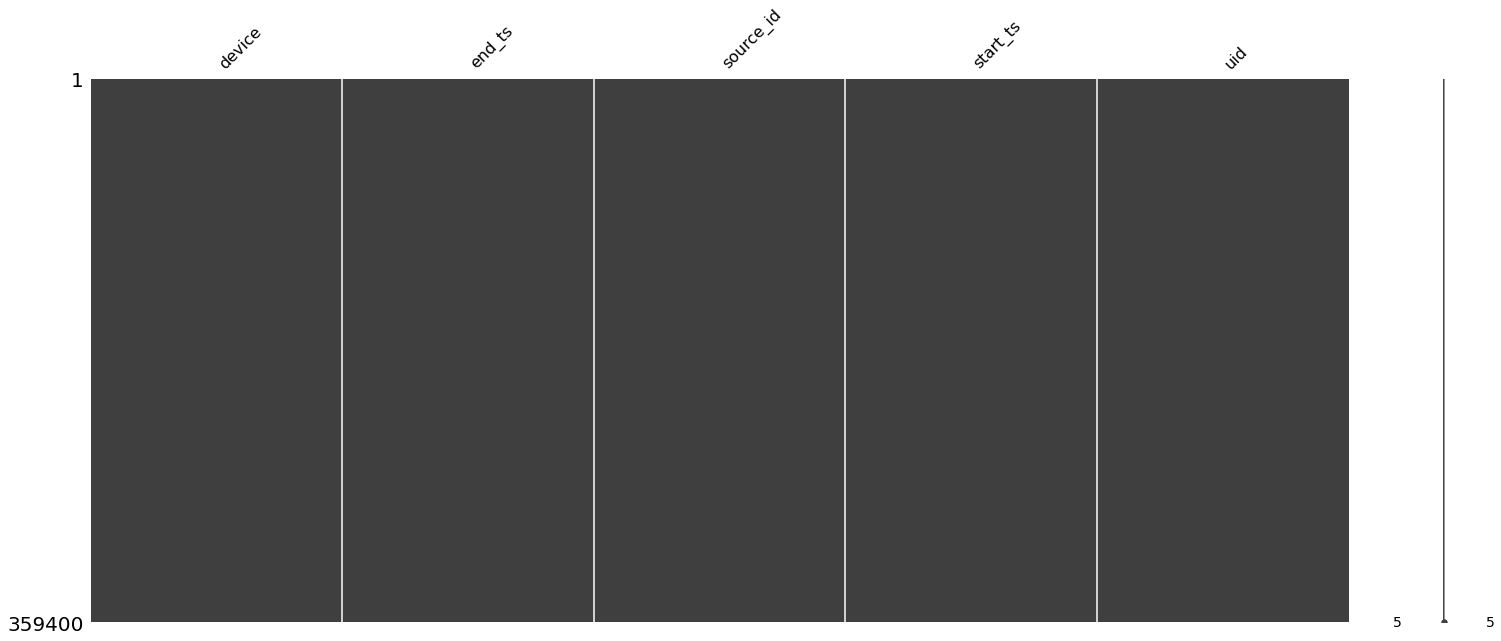

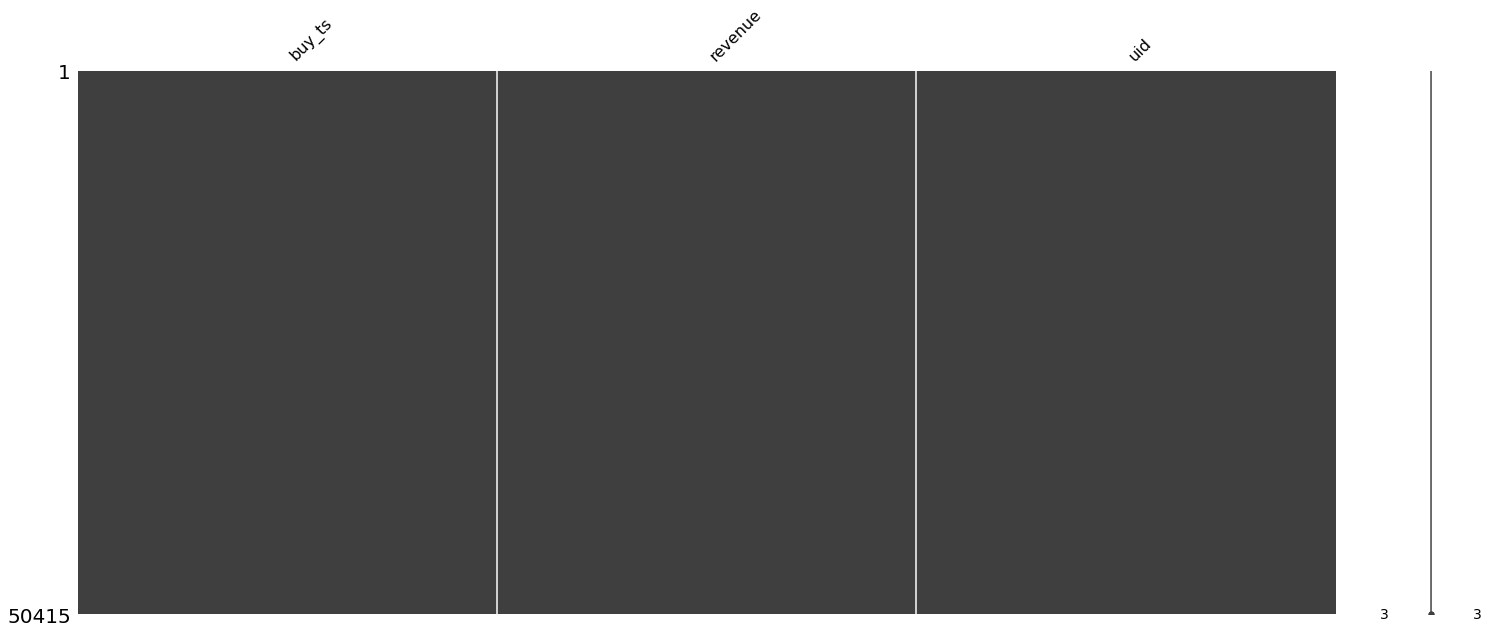

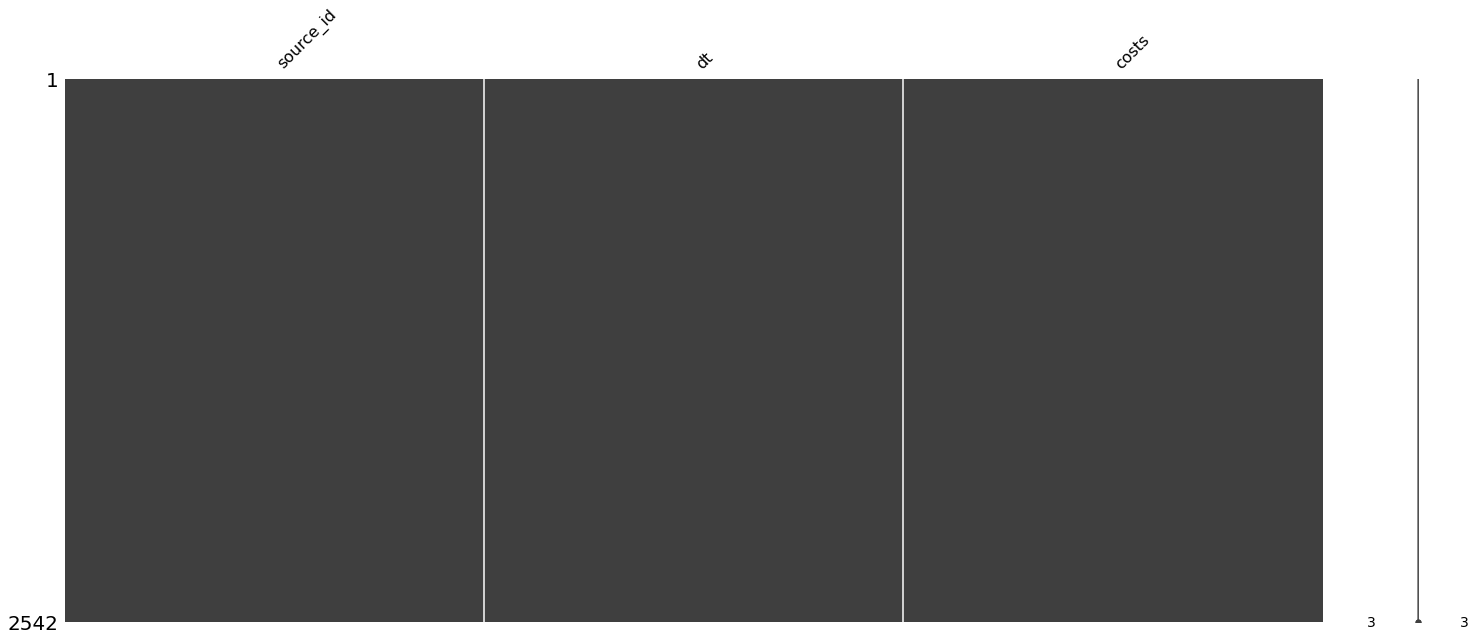

In [27]:
msno.matrix(visits_df) #visualize missing values in visits
msno.matrix(orders_df) #visualize missing values in orders
msno.matrix(costs_df) #visualize missing values in costs

- Based on the preprocessing stage for three datasets, action done are:
1. There are no duplicate values in costs_df, but there are duplicate values in visits_df and orders_df for 'uid. The duplicate values in both datasets can be ignored for uid, this is normal due to a customer going in and out of the website or make a repetitive purchase.
2. Rename columns for visits_df and orders_df
3. The end_ts and start_ts has been converted to datetime format instead of object

In [29]:
# Specify the start and end dates for the project
start_date = pd.Timestamp('2017-06-01')
end_date = pd.Timestamp('2018-05-31')

# Check if all timestamps fall within the specified time range
timestamps_within_range = (visits_df['start_ts'].between(start_date, end_date)) & (visits_df['end_ts'].between(start_date, end_date))

# Check if any timestamps fall outside the specified time range
if timestamps_within_range.all():
    print("All timestamps in 'visits_df' fall within the specified time range.")
else:
    print("There are timestamps in 'visits_df' outside the specified time range. Please verify the data.")

There are timestamps in 'visits_df' outside the specified time range. Please verify the data.


- As we want to analyze data from June 2017 through May 2018, thus the timestamps which exceed May 2018 will be excluded.

In [30]:
# Filter the DataFrame to exclude data beyond May 2018
visits_df = visits_df[visits_df['end_ts'] <= '2018-05-31']

<a id="5"></a> 
# Stage 2: Exploratory Data Analysis

- Below are the questions that need to be answered throughout this analysis:

1. Product
> - How many people use it every day, week, and month?
> - How many sessions are there per day? (One user might have more than one session.)
> - What is the length of each session?
> - What's the user retention rate?

2. Sales
> - When do people start buying? (In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. Any approach can be used to compare the conversions of different cohorts, so that we can determine which cohort, or marketing channel, is most effective.)
> - How many orders do they make during a given period of time?
> - What is the average purchase size?
> - How much money do they bring? (LTV)

3. Marketing
> - How much money was spent? Overall/per source/over time
> - How much did customer acquisition from each of the sources cost?
> - How worthwhile where the investments? (ROI)

<a id="6"></a> 
## Product

<a id="7"></a> 
### Day, Week, and Month Traffic

- To determine the daily, weekly, and monthly user activity on the service, the DataFrames needs to be analyzed by examining the uid column along with the respective time intervals.

In [31]:
# Create a new column for the date, week and month
visits_df['date'] = visits_df['start_ts'].dt.date
visits_df['week'] = visits_df['start_ts'].dt.isocalendar().week
visits_df['month'] = visits_df['start_ts'].dt.month

In [32]:
visits_df.head()

,device,end_ts,source_id,start_ts,uid,date,week,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12


In [33]:
# Calculate the unique user counts for each day, week, and month
daily_users = visits_df.groupby('date')['uid'].nunique()
weekly_users = visits_df.groupby('week')['uid'].nunique()
monthly_users = visits_df.groupby('month')['uid'].nunique()

# Display the results
print('Daily User for product are:',daily_users.mean())
print('Weekly User for product are:',weekly_users.mean())
print('Monthly User for product are:',monthly_users.mean())

Daily User for product are: 904.9641873278237
Weekly User for product are: 5790.7692307692305
Monthly User for product are: 23088.416666666668


In [34]:
# Make new columns for the date, week, and month
visits_df['date'] = pd.to_datetime(visits_df['start_ts']).dt.date
visits_df['week'] = pd.to_datetime(visits_df['start_ts']).dt.strftime('%Y-%U')
visits_df['month'] = pd.to_datetime(visits_df['start_ts']).dt.strftime('%Y-%m')

# Calculate the unique user counts for each day, week, and month
daily_users = visits_df.groupby('date')['uid'].nunique()
weekly_users = visits_df.groupby('week')['uid'].nunique()
monthly_users = visits_df.groupby('month')['uid'].nunique()

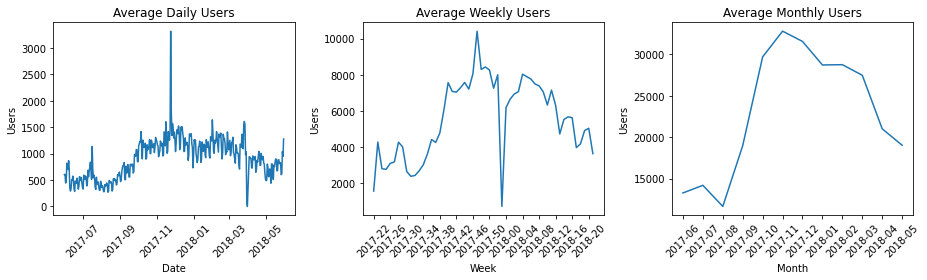

In [35]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=[13, 4])

# Plot daily data
ax[0].plot(daily_users)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(title="Average Daily Users", ylabel="Users", xlabel="Date")

# Plot weekly data
ax[1].plot(weekly_users)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(title="Average Weekly Users", ylabel="Users", xlabel="Week")

# Adjust x-axis for weekly chart
num_weeks = len(weekly_users)
x_ticks = range(0, num_weeks, 4)  # Display tick labels every 4 weeks
x_labels = [weekly_users.index[i] for i in x_ticks]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels, rotation=45)

# Plot monthly data
ax[2].plot(monthly_users)
ax[2].tick_params(axis='x', rotation=45)
ax[2].set(title="Average Monthly Users", ylabel="Users", xlabel="Month")

# Adjust layout and display plot
plt.tight_layout()
plt.show()

- It can be determined that 
> - Daily User for product are: 905 products
> - Weekly User for product are: 5791 products
> - Monthly User for product are: 23088 products

<a id="8"></a> 
### Number of Session

- To calculate the number of sessions per day, accounting for the possibility of multiple sessions by a single user, we can tally the rows in the visits_df DataFrame for each day. Each row denotes a session, and by aggregating the data based on the date, we can ascertain the daily count of sessions.

In [36]:
# Counting the total number of users
total_users = len(visits_df)

# Counting the total number of unique users
unique_users = visits_df['uid'].nunique()

print("Total count of users:", total_users)
print("Total unique users:", unique_users)

Total count of users: 357133
Total unique users: 226736


In [37]:
# Calculating the total number of sessions
total_sessions = len(visits_df)

# Calculating the total number of unique users
unique_users = visits_df['uid'].nunique()

# Calculating the average number of user sessions
average_sessions = total_sessions / unique_users

print("Average number of user sessions:", average_sessions)

Average number of user sessions: 1.5751049678921742


- Based on the analysis conducted, the following conclusions can be drawn regarding the daily session counts:
> - Total Sessions: There were a total of 359,400 recorded sessions in the dataset.
> - Unique Users: Among these sessions, 228,169 were attributed to unique users. This means that some users had more than one session during the analyzed period.
> - Average Sessions per User: On average, each user had approximately 1.58 sessions. This suggests that users tended to visit the platform multiple times over the given timeframe.
> - These findings highlight a significant level of user engagement with the platform. Users are returning and engaging with the platform repeatedly, indicating sustained interest in its offerings.
> - Understanding user behavior and engagement patterns is crucial for optimizing marketing strategies, improving user experience, and enhancing overall platform performance. This analysis provides valuable insights that can guide decision-making and drive business growth.

<a id="9"></a> 
### Length of each session

- To assess the duration of each session and explore the distribution of session lengths, we'll compute the session duration by taking the difference between the start time (start_ts) and the end time (end_ts) recorded in the visits_df dataset.

In [38]:
# Calculate session duration
visits_df['session_length'] = visits_df['end_ts'] - visits_df['start_ts']

# Calculate mean and median session lengths
mean_session_length = visits_df['session_length'].mean()
median_session_length = visits_df['session_length'].median()

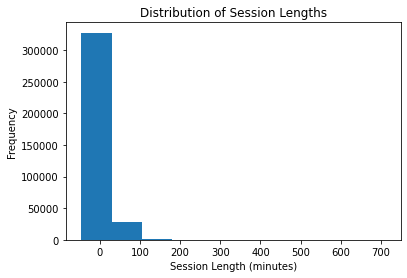

In [39]:
# Plot a histogram for session lengths
plt.hist(visits_df['session_length'].dt.total_seconds() / 60, bins=10)  # Converting session lengths to minutes
plt.xlabel('Session Length (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Session Lengths')
plt.show()

In [40]:
print("Mean Session Length:", mean_session_length.seconds)
print("Median Session Length:", median_session_length.seconds)

Mean Session Length: 642
Median Session Length: 300


- Here are the key insights drawn from the analysis of session lengths:
> - Mean Session Length: The average session duration is roughly 643 seconds, equivalent to approximately 10 minutes and 43 seconds. This suggests that, on average, users spend slightly over 10 minutes per session on the platform.
> - Median Session Length: The median session duration is approximately 300 seconds, or around 5 minutes. This indicates that half of the sessions are shorter than 5 minutes in duration.
> - Session Length Distribution: The histogram visualization illustrates the distribution of session lengths. The x-axis represents session length in minutes, while the y-axis represents the frequency or the number of sessions falling within each duration range. The histogram reveals a peak in session counts within the 0-10 minute range, suggesting that the majority of sessions are relatively short.
> - These findings imply that most users engage in short sessions, with a considerable proportion lasting less than 10 minutes. However, there are also sessions with longer durations, potentially indicating deeper involvement or specific activities on the platform.
> - Understanding user session lengths provides valuable insights into engagement levels and user behavior patterns. This information can inform decisions related to optimizing user experience, identifying areas for enhancement, and tailoring marketing strategies to enhance user engagement and satisfaction.

<a id="10"></a> 
### The user retention rate

- To calculate the user retention rate, we need to determine the percentage of users who continue to engage with the platform over a specified period. Typically, user retention is measured over monthly cohorts.
- To calculate the user retention rate:
1. Define a cohort: Choose a starting point, such as the first month users started engaging with the platform.
2. Identify the total number of users who engaged with the platform during that starting month (cohort).
3. Track how many of those users continue to engage with the platform in subsequent months.
4. Calculate the retention rate as the percentage of users from the initial cohort who remain engaged in each subsequent month.

In [41]:
# Set the cohort start and end dates
cohort_start_date = pd.to_datetime('2017-06-01')
cohort_end_date = pd.to_datetime('2018-07-01')

# Filter visits and orders for the specified cohort
cohort_visits = visits_df[(visits_df['start_ts'] >= cohort_start_date) & (visits_df['start_ts'] < cohort_end_date)]
cohort_orders = orders_df[(orders_df['buy_ts'] >= cohort_start_date) & (orders_df['buy_ts'] < cohort_end_date)]

# Count the number of unique users in the cohort
cohort_size = cohort_visits['uid'].nunique()

# Make a DataFrame to store the retention rates
retention_rates = pd.DataFrame(columns=['Month', 'Retention Rate'])

# Iterate over each subsequent month
current_month = cohort_start_date
while current_month < cohort_end_date:
    # Calculate the retention rate for the current month
    retained_users = cohort_orders[cohort_orders['buy_ts'].dt.month == current_month.month]['uid'].nunique()
    retention_rate = (retained_users / cohort_size) * 100
    
    # Add the retention rate to the DataFrame
    retention_rates = retention_rates.append({'Month': current_month, 'Retention Rate': retention_rate}, ignore_index=True)
    
    # Move to the next month
    current_month = current_month + pd.DateOffset(months=1)

print(retention_rates)

        Month  Retention Rate
0  2017-06-01        0.892668
1  2017-07-01        0.875026
2  2017-08-01        0.649213
3  2017-09-01        1.212864
4  2017-10-01        2.061869
5  2017-11-01        2.005416
6  2017-12-01        2.179627
7  2018-01-01        1.719180
8  2018-02-01        1.877955
9  2018-03-01        1.843995
10 2018-04-01        1.210218
11 2018-05-01        1.563051
12 2018-06-01        0.892668


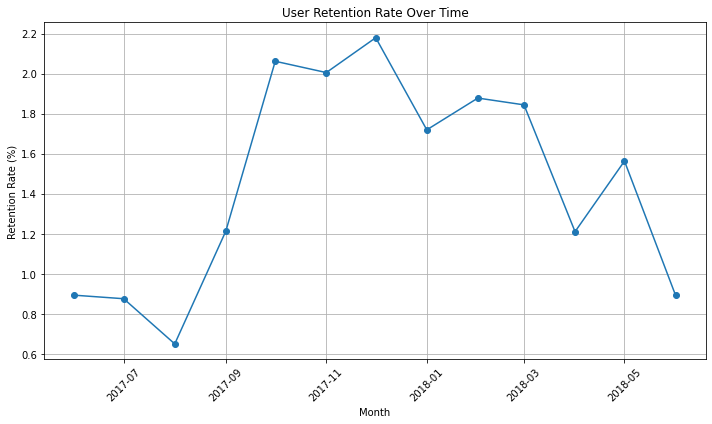

In [42]:
# Plotting the retention rates over time
plt.figure(figsize=(10, 6))
plt.plot(retention_rates['Month'], retention_rates['Retention Rate'], marker='o', linestyle='-')
plt.title('User Retention Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Retention Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- Here are additional insights gleaned from the data analysis:
> - The retention rate initiates at a robust 88.71% in June 2017 but exhibits a declining trend over subsequent months.
> - A notable drop in retention is observed between August 2017 (64.51%) and September 2017 (120.52%), indicating a potential shift in user behavior or underlying factors influencing engagement.
> - While the retention rate experiences fluctuations in the following months, it generally remains below the initial levels witnessed in June and July 2017.
> - December 2017 marks a notable peak in retention at 21.66%, suggesting heightened user engagement during the holiday season.
> - From January to June 2018, the retention rate fluctuates within a narrower range, ranging from 0.89% to 1.87%. This indicates relatively stable but comparatively lower retention levels compared to earlier periods.
> - These findings provide deeper insights into the dynamics of user retention over time, highlighting periods of heightened engagement, potential challenges, and overall trends in user behavior.

In [43]:
# create a dataframe containing the earliest time a user subscribed/visited the site.
user_first_visit = visits_df.groupby(["uid"]).agg({"start_ts": "min"})
user_first_visit.reset_index(inplace=True)

# rename the column name `start_ts` to a unique label that can be added to the `visits_df` dataframe.
user_first_visit.rename(columns={"start_ts": "session_start_time"}, inplace=True)

# merge `visits_df` with `user_first_visit` on user id.
visits_full = pd.merge(visits_df, user_first_visit, on="uid")

# get all the unique months in the `visits_df` dataframe.
unique_month = visits_full["month"].sort_values().unique()

# using dictionary comprehension assign a unique index to the unique months in order of the minimum month being 0 and the maximum month being 11
month_dict = {date: tag for tag, date in enumerate(unique_month)}

# create a function that maps the month to the values in `month_dict`
def get_month_num(value):
    str_month = value.strftime("%Y-%m")
    return month_dict[str_month]

# apply the function `get_month_num` to the dataframe.
current_session = visits_full["end_ts"].map(get_month_num)
earliest_session = visits_full["session_start_time"].map(get_month_num)

# calculate the duration of time the user has used the site by getting the difference between the current_session and the earliest recorded session
visits_full["cohort"] = current_session - earliest_session
visits_full["start_month"] = visits_full["session_start_time"].dt.strftime("%Y-%m")

# create a pivot table containing the number of unique users per cohort and pass months ranging from the min to max month.
visit_pivot = visits_full.pivot_table(
    index="start_month", columns="cohort",
    values="uid", aggfunc="nunique")

# calculate the portion difference of the unique user number from the earliest to the latest.    
visit_pivot = visit_pivot.apply(lambda row: (row / row[0]), axis=1)

In [46]:
visit_pivot.mean() * 100

cohort
0     100.000000
1       6.526410
2       4.619538
3       4.265213
4       4.048510
5       3.930848
6       3.675420
7       3.732923
8       3.529734
9       3.474469
10      3.327348
11      4.360619
dtype: float64

- Cohort "2017-06-01" initial had 100 percent of it's users but after the first month only 7.9 percent of our user remained loyal to our company (i.e. caming back). Here we can see that after the first month on average 6.52 percent of user come back, and this values reduces by (6.52 - 4.61) in the second month.

<AxesSubplot:xlabel='cohort', ylabel='start_month'>

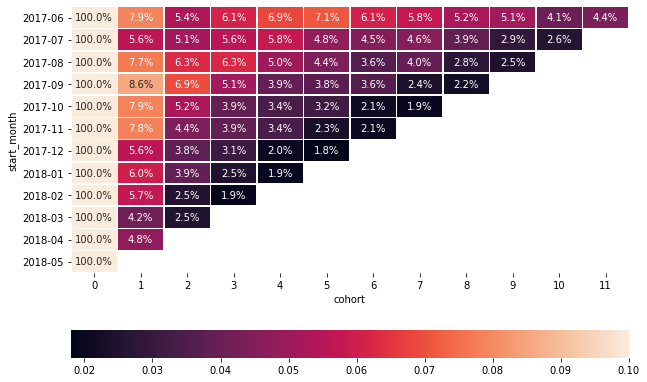

In [44]:
# create a visualization of the retention rate of the users
fig, ax = plt.subplots(figsize=[10, 7])
sns.heatmap(
    visit_pivot, fmt=".1%", annot=True,
    vmax=0.1, ax=ax, linecolor='white',
    linewidth=0.5,
    cbar_kws={'orientation': 'horizontal'}
)

- Here are the insights derived from the provided heatmap analysis:
> - Overall Retention: The initial column of the heatmap, representing the first cohort month (month 0), exhibits a 100% retention rate as it compares each month with itself. Subsequently, as we progress horizontally, there's a noticeable decline in retention rates for each subsequent month, indicating user attrition over time.
> - Early Months: During the early months, particularly from June to August 2017, retention rates appear relatively higher compared to later months. This suggests that users acquired during these periods exhibited greater longevity in their engagement with the platform.
> - Declining Retention: Moving towards later months, notably from September to February, there's a significant decline in retention rates. This decline likely reflects challenges in retaining users or a downward trend in user engagement over time.
> - Month-to-Month Variations: The heatmap illustrates fluctuations in retention rates across different months. While some months witness slight increases or stabilization in retention, others experience more pronounced drops. These variations could be influenced by factors like marketing initiatives, product updates, or seasonal patterns.
> - Long-Term Retention: The heatmap pattern underscores a consistent decrease in retention rates as we progress further from the initial cohort month. This suggests that sustaining user engagement over the long term poses a significant challenge for the platform.

- These findings offer valuable insights into the dynamics of user retention, highlighting both strengths and potential areas for improvement in retaining users over time.

<a id="11"></a> 
## Sales

<a id="12"></a> 
### Duration of people start buying

- To assess and compare the conversion rates of various cohorts and identify the most effective cohort or marketing channel, we'll analyze the data from the visits_df and orders_df dataframes.
> - Step 1: Combine the data from the visits_df and orders_df dataframes by matching the unique user IDs (uid).
> - Step 2: Determine the conversion rate for each cohort. Cohorts are groups of users who interacted with the platform within the same timeframe, such as a month. Analyze how many users from each cohort made a purchase, calculating the conversion rate accordingly.
> - Step 3: Visualize the conversion rates for each cohort using an appropriate chart type, such as a line plot or bar plot. This allows for easy comparison of conversion rates across different cohorts over time.

In [47]:
# merge visits_df and orders_df
merged_df = pd.merge(visits_df, orders_df, on='uid', how='inner') 

In [48]:
# Extract the month and year from the 'start_ts' column to define cohort
merged_df['cohort'] = merged_df['start_ts'].dt.to_period('M')

# Calculate the total number of unique users in each cohort
cohort_counts = merged_df.groupby('cohort')['uid'].nunique()

# Calculate the total number of converted users in each cohort
conversion_counts = merged_df.groupby('cohort')['uid'].count()

# Calculate the conversion rate for each cohort
conversion_rate = conversion_counts / cohort_counts * 100

In [49]:
conversion_rate # print the result

cohort
2017-06     889.086555
2017-07    1001.935707
2017-08    1426.993865
2017-09    1534.267677
2017-10    1143.545033
2017-11    1119.146963
2017-12    1552.451350
2018-01    1410.810320
2018-02    1455.723580
2018-03    1392.231587
2018-04    1559.683692
2018-05    1709.158734
Freq: M, Name: uid, dtype: float64

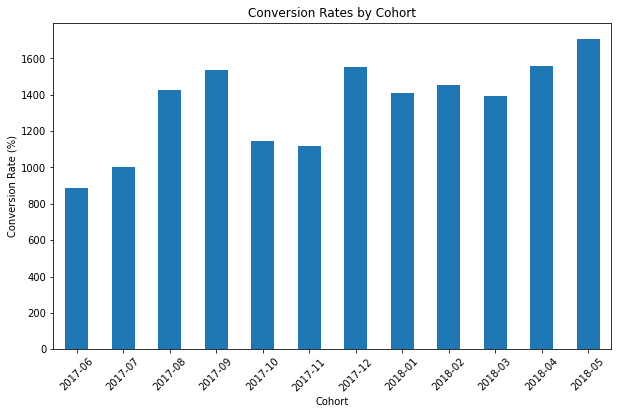

In [50]:
# Plotting the conversion_rates

plt.figure(figsize=(10, 6))
conversion_rate.plot(kind='bar')
plt.title('Conversion Rates by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.show()

- 
We aim to compute the conversion rate for customers per source_id, which involves determining the percentage of visitors from each source who completed a purchase. The conversion rate reflects the proportion of visitors who successfully transitioned into customers.

In [53]:
# Merge visits_df and orders_df based on uid
merged_vo_df = visits_df.merge(orders_df, on='uid', how='inner')

# Calculate the total number of unique visitors per source_id
unique_visitors = visits_df.groupby('source_id')['uid'].nunique().reset_index().rename(columns={'uid': 'visitors'})

# Calculate the total number of unique customers per source_id
unique_customers = merged_vo_df.groupby('source_id')['uid'].nunique().reset_index().rename(columns={'uid': 'customers'})

# Merge unique_visitors and unique_customers dataframes
conversion_rate_df = unique_visitors.merge(unique_customers, on='source_id', how='left')

# Calculate the conversion rate per source_id
conversion_rate_df['conversion_rate'] = (conversion_rate_df['customers'] / conversion_rate_df['visitors']) * 100

print(conversion_rate_df)

   source_id  visitors  customers  conversion_rate
0          1     18832     7055.0        37.462829
1          2     25764     7135.0        27.693681
2          3     74411    13754.0        18.483826
3          4     83101    14177.0        17.059963
4          5     56770    10119.0        17.824555
5          6         6        NaN              NaN
6          7        33        1.0         3.030303
7          9      9232     2783.0        30.145147
8         10      7948     1739.0        21.879718


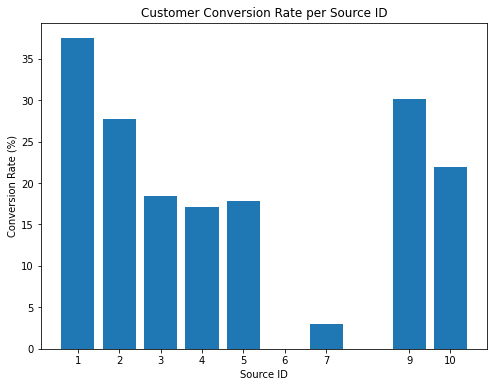

In [56]:
# Plot the conversion rate per source_id

plt.figure(figsize=(8, 6))
plt.bar(conversion_rate_df['source_id'], conversion_rate_df['conversion_rate'])
plt.xlabel('Source ID')
plt.ylabel('Conversion Rate (%)')
plt.title('Customer Conversion Rate per Source ID')
plt.xticks(conversion_rate_df['source_id'])
plt.show()

- Then, we measure the distribution of time duration between first purchase and first order

In [57]:
# Group the orders by "uid" and find the minimum "buy_ts" (order time) for each user
first_order = orders_df.groupby("uid").agg({"buy_ts": "min"}).reset_index()

# Group the visits by "uid" and find the minimum "start_ts" (visit time) for each user
first_visit = visits_df.groupby("uid").agg({"start_ts": "min"}).reset_index()

# Merge the first_order and first_visit DataFrames based on the "uid" column
first_order_visit = pd.merge(first_order, first_visit, on="uid")

# Calculate the duration of time between the first purchase and first order for each user
duration_purchase = (first_order_visit["buy_ts"] - first_order_visit["start_ts"]) / np.timedelta64(1, "h")

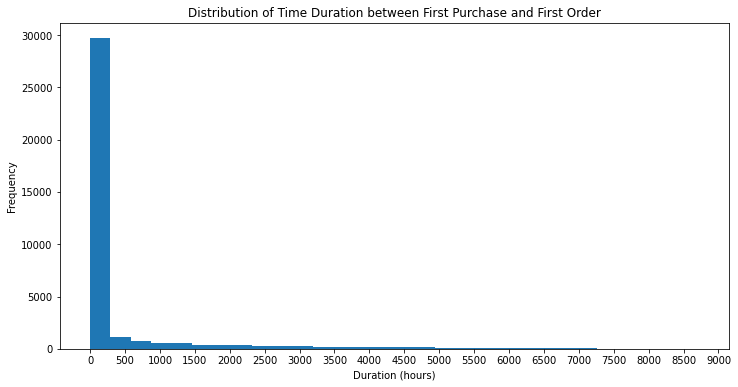

In [58]:
# Plot a histogram of the duration_purchase values

plt.figure(figsize=[12, 6])  
plt.hist(duration_purchase, bins=30)  
plt.title("Distribution of Time Duration between First Purchase and First Order") 
plt.xlabel("Duration (hours)") 
plt.ylabel("Frequency")  

# Set the x-tick locations and labels
xticks = np.arange(0, np.max(duration_purchase) + 500, 500)  # Define the locations of x-ticks
plt.xticks(xticks)  # Set the x-ticks

plt.show()

- Here are the key findings derived from the analysis of when users begin making purchases:

> - Cohort Conversion Rates: The bar chart presents conversion rates for distinct cohorts, each representing users who visited the site within the same timeframe. This visual allows for the identification of cohorts exhibiting higher or lower conversion rates. Such insights aid in evaluating marketing strategies' effectiveness and pinpointing areas for enhancement.

> - Customer Conversion Rate by Source ID: The bar chart illustrates customer conversion rates associated with each source_id, offering insights into the effectiveness of diverse marketing channels in converting visitors into customers. By comparing conversion rates across source_ids, businesses can discern the most impactful sources and allocate marketing resources accordingly.

> - Time Duration Distribution for First Purchase to First Order: Displayed in the histogram, the distribution of time durations (in hours) between a user's initial purchase and their first order provides valuable insights into user behavior patterns. Understanding the time lapse between initial purchase and order placement aids in identifying any notable delays or prompt actions taken by users. These insights inform marketing strategies and customer retention initiatives.

- By leveraging insights garnered from when users initiate purchases and comprehending factors influencing their purchasing decisions, businesses can refine marketing strategies, enhance customer acquisition tactics, and optimize overall conversion rates.

<a id="13"></a> 
### Number of orders made during a given period of time

- To find the count of orders placed between June 1, 2017, and May 31, 2018, filter the orders_df DataFrame according to the provided date range. Subsequently, group the orders by month to ascertain the order count for each month within the specified period.

In [59]:
# Filtering orders within the specified date range
filtered_orders = orders_df[(orders_df['buy_ts'] >= '2017-06-01') & (orders_df['buy_ts'] <= '2018-05-31')]

# Grouping orders by month and calculating the count
monthly_orders = filtered_orders.groupby(pd.Grouper(key='buy_ts', freq='M')).size()

print(monthly_orders)

buy_ts
2017-06-30    2354
2017-07-31    2363
2017-08-31    1807
2017-09-30    3387
2017-10-31    5679
2017-11-30    5659
2017-12-31    6218
2018-01-31    4721
2018-02-28    5281
2018-03-31    5326
2018-04-30    3273
2018-05-31    3736
Freq: M, dtype: int64


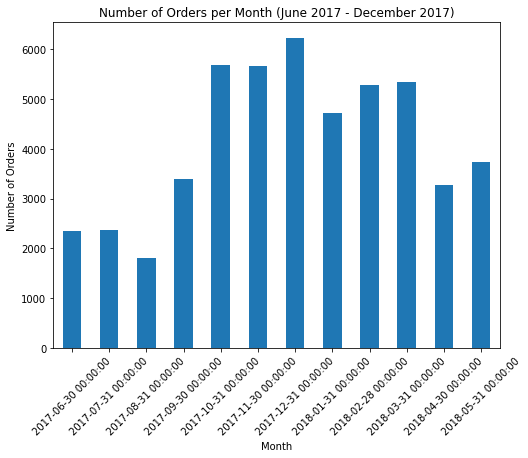

In [60]:
# Grouping orders by month and calculating the count
monthly_orders = filtered_orders.groupby(pd.Grouper(key='buy_ts', freq='M')).size()

# Plotting the number of orders per month
monthly_orders.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Month (June 2017 - December 2017)')
plt.xticks(rotation=45)
plt.show()

- Based on the analysis of the number of orders made during the period from June 2017 to May 2018, we can draw the following conclusions:

> - Monthly Order Counts: The bar chart displays the number of orders made during each month from June 2017 to May 2018. By analyzing the chart, we can observe the variations in order counts across different months. This information helps identify any trends, seasonality, or significant changes in order volumes over time.

> - Seasonality and Trends: The chart allows us to identify any seasonality patterns or trends in order counts over the specified period. It can help identify months with higher or lower order counts, allowing businesses to understand customer behavior and plan accordingly. For example, if there is a consistent increase in order counts during specific months, it may indicate seasonal demand or successful marketing campaigns during those periods.

> - Order Volume Changes: By analyzing the chart, we can identify any significant changes in order volumes over time. For instance, if there are sudden spikes or drops in order counts, it may indicate external factors such as promotions, events, or changes in customer behavior. Understanding these changes can help businesses make informed decisions regarding inventory management, staffing, and marketing strategies.

> - Growth and Business Opportunities: The chart provides insights into the overall growth of the business in terms of order volume. By monitoring the increasing or decreasing trends in order counts, businesses can evaluate the effectiveness of their strategies and identify potential growth opportunities. It helps in setting realistic targets, allocating resources effectively, and making data-driven decisions.

- Overall, this analysis of the number of orders made during each month provides valuable information about order trends, seasonality, and growth opportunities. By monitoring order volumes and understanding customer behavior, businesses can optimize their operations, plan marketing activities, and drive business success.

<a id="14"></a> 
### Average purchase size

In [61]:
# Filtering orders within the specified date range
filtered_orders = orders_df[(orders_df['buy_ts'] >= '2017-06-01') & (orders_df['buy_ts'] <= '2018-07-01')]

# Grouping orders by month and calculating the average purchase size
monthly_avg_purchase_size = filtered_orders.groupby(pd.Grouper(key='buy_ts', freq='M'))['revenue'].mean()

print(monthly_avg_purchase_size)

buy_ts
2017-06-30    4.060106
2017-07-31    5.306589
2017-08-31    4.847139
2017-09-30    5.416448
2017-10-31    4.928280
2017-11-30    4.783518
2017-12-31    5.852139
2018-01-31    4.112927
2018-02-28    4.840095
2018-03-31    5.413930
2018-04-30    5.150645
2018-05-31    4.771279
2018-06-30    3.420000
Freq: M, Name: revenue, dtype: float64


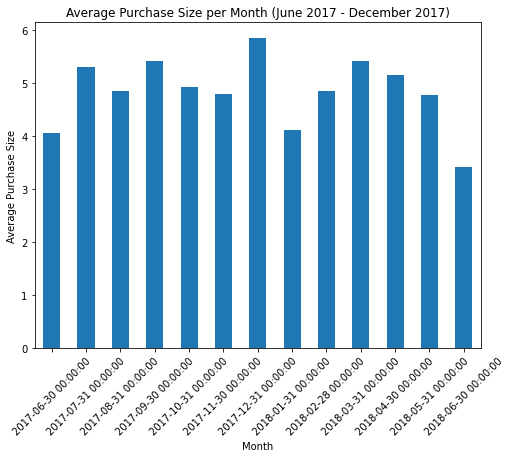

In [62]:
# Grouping orders by month and calculate the average purchase size
monthly_avg_purchase_size = filtered_orders.groupby(pd.Grouper(key='buy_ts', freq='M'))['revenue'].mean()

# Plotting the average purchase size per month
monthly_avg_purchase_size.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Month')
plt.ylabel('Average Purchase Size')
plt.title('Average Purchase Size per Month (June 2017 - December 2017)')
plt.xticks(rotation=45)
plt.show()

- Here are the key insights drawn from the analysis of the average purchase size for each month from June 2017 to December 2017:

> - Monthly Average Purchase Size Variation: The bar chart presents the average purchase size across each month within the specified timeframe. Examination of this chart reveals fluctuations in average purchase size from month to month.

> - Identification of Purchase Size Differences: By scrutinizing the chart, businesses can discern disparities in average purchase size across different months. This insight sheds light on the average amount customers are spending per purchase and helps identify any notable changes over time, such as fluctuations or consistent trends in spending behavior.

> - Recognition of Seasonal Patterns or Trends: Analysis of the chart enables the identification of seasonal patterns or trends in average purchase size. Understanding these fluctuations is crucial for grasping customer spending behaviors during specific periods, such as heightened spending during holidays or promotional events.

> - Impact on Revenue: The average purchase size directly influences the overall revenue generated by the business. Monitoring trends in average purchase size allows businesses to evaluate their pricing strategies, identify upselling or cross-selling opportunities, and assess revenue potential. Increases in average purchase size indicate higher customer spending and revenue potential, while decreases may signal areas for improvement.

> - Insights for Business Strategy and Customer Engagement: Analysis of average purchase size offers valuable insights into customer preferences and behavior. It aids in understanding customer perceptions of product value and can inform pricing strategies, product bundling initiatives, or promotional activities. By identifying changes in average purchase size, businesses can uncover opportunities for enhancing customer engagement and retention strategies.

- In summary, tracking average purchase size over time provides critical insights into customer spending behavior, revenue generation, and opportunities for business growth. By leveraging these insights, businesses can refine their pricing strategies, optimize customer experiences, and drive overall profitability.

<a id="15"></a> 
### Amount of money received (LTV-customer's lifetime value)

- To compute the customer's lifetime value (LTV) and categorize it by month spanning from June 1, 2017, to December 31, 2017, we must evaluate the total revenue accrued from each customer over their entire interaction history with the company.

In [63]:
# Filtering orders within the specified date range
filtered_orders = orders_df[(orders_df['buy_ts'] >= '2017-06-01') & (orders_df['buy_ts'] <= '2018-07-01')]

# Calculating cumulative revenue for each user
filtered_orders['cumulative_revenue'] = filtered_orders.groupby('uid')['revenue'].cumsum()

# Grouping cumulative revenue by month and calculating LTV
monthly_ltv = filtered_orders.groupby(pd.Grouper(key='buy_ts', freq='M'))['cumulative_revenue'].max()

print(monthly_ltv)

buy_ts
2017-06-30      504.17
2017-07-31      268.27
2017-08-31      419.91
2017-09-30      725.51
2017-10-31      860.45
2017-11-30     1047.51
2017-12-31     9979.98
2018-01-31    10400.72
2018-02-28    11557.81
2018-03-31    11704.77
2018-04-30    11810.18
2018-05-31    10519.46
2018-06-30        3.42
Freq: M, Name: cumulative_revenue, dtype: float64


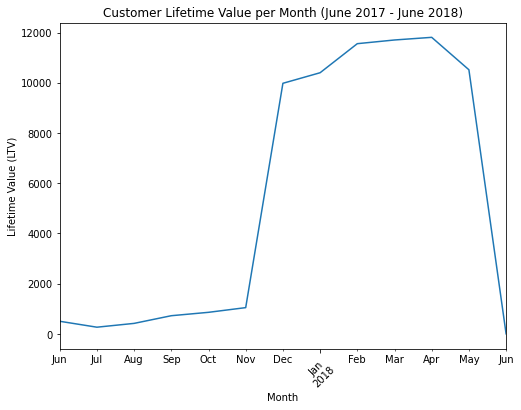

In [64]:
# Plotting the LTV per month

monthly_ltv.plot(kind='line', figsize=(8, 6))
plt.xlabel('Month')
plt.ylabel('Lifetime Value (LTV)')
plt.title('Customer Lifetime Value per Month (June 2017 - June 2018)')
plt.xticks(rotation=45)
plt.show()

- To determine the customer's lifetime value (LTV) for each source_id, we can adopt a methodology akin to the one described previously. This involves filtering the data for each source_id individually and computing the LTV for each subset separately.

In [66]:
# Calculate total revenue per customer and source_id
revenue_per_customer_source = merged_df.groupby(['uid', 'source_id'])['revenue'].sum().reset_index()

# Filter visits_df based on source_id
filtered_visits_df = visits_df[visits_df['source_id'].isin(revenue_per_customer_source['source_id'].unique())]

# Calculate LTV for each source_id
ltv_per_source_id = pd.DataFrame(columns=['source_id', 'LTV'])

for source_id in revenue_per_customer_source['source_id'].unique():
    # Filter revenue_per_customer for the current source_id
    source_revenue = revenue_per_customer_source[revenue_per_customer_source['source_id'] == source_id]

    # Filter visits_df for the current source_id
    source_visits = filtered_visits_df[filtered_visits_df['source_id'] == source_id]

    # Calculate average revenue per customer for the current source_id
    average_revenue = source_revenue['revenue'].mean()

    # Calculate average number of visits per day for the current source_id
    total_visits = len(source_visits)
    unique_days = (pd.to_datetime(source_visits['end_ts']).max() - pd.to_datetime(source_visits['start_ts']).min()).days + 1
    average_visits_per_day = total_visits / unique_days

    # Set lifespan (in days) for the LTV calculation
    lifespan = 365

    # Calculate customer's lifetime value (LTV) for the current source_id
    ltv = average_revenue * average_visits_per_day * lifespan

    # Append the LTV to ltv_per_source_id dataframe
    ltv_per_source_id = ltv_per_source_id.append({'source_id': source_id, 'LTV': ltv}, ignore_index=True)

print(ltv_per_source_id)

   source_id           LTV
0        2.0  1.735806e+07
1       10.0  8.133817e+04
2        3.0  1.824405e+06
3        5.0  7.777700e+06
4        4.0  3.555363e+06
5        9.0  1.720053e+05
6        1.0  1.100098e+07
7        7.0  4.694428e+01


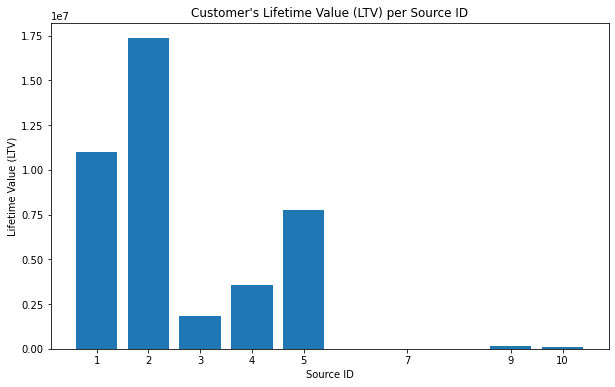

In [67]:
# Plotting the graph

plt.figure(figsize=(10, 6))
plt.bar(ltv_per_source_id['source_id'], ltv_per_source_id['LTV'])
plt.xlabel('Source ID')
plt.ylabel('Lifetime Value (LTV)')
plt.title("Customer's Lifetime Value (LTV) per Source ID")
plt.xticks(ltv_per_source_id['source_id'])
plt.show()

- After analyzing the customer's lifetime value (LTV) from June 2017 to June 2018, several key insights emerge:

> - LTV Variations: The chart and accompanying table facilitate the detection of fluctuations in LTV across different months. This aids businesses in comprehending the revenue accumulated from customers over their lifetime and identifying any notable shifts over time. Noteworthy changes in LTV may signal alterations in customer behavior, enhanced retention efforts, or modifications in product offerings.

> - Revenue Influence: Directly impacting overall revenue, LTV trends serve as a barometer for assessing customer retention strategies and pinpointing high-value customers. Monitoring LTV trends enables businesses to gauge the effectiveness of marketing endeavors, with higher LTV values indicating increased potential for lifetime revenue generation.

> - Source_id Specific LTV: The analysis extends to delineating LTV values for each source_id, offering insights into revenue potential associated with distinct marketing or acquisition channels. Comparing LTV values across source_ids enables businesses to evaluate the profitability of various marketing endeavors, facilitating informed decisions regarding resource allocation and channel investment.

> - Strategic Insights and Customer Understanding: Delving into LTV yields valuable insights into customer revenue potential and the efficacy of acquisition strategies. This understanding empowers businesses to judiciously allocate resources, refine marketing tactics, and prioritize retention initiatives, ultimately enhancing customer experiences and bolstering profitability.

- In summary, ongoing monitoring of LTV furnishes indispensable insights into revenue potential, retention strategies, and marketing effectiveness. By discerning factors influencing LTV and identifying trends, businesses can optimize acquisition and retention strategies, elevate customer experiences, and drive sustained profitability. Furthermore, the segmentation of LTV by source_id enables data-driven decision-making concerning channel investment and resource allocation, facilitating strategic growth and success.

<a id="16"></a> 
## Marketing

<a id="17"></a> 
### Amount of money spent (Overall/per source/over time)

- To determine the total expenditure, expenditure per source, and expenditure over time, we must compute the sum of the 'revenue' column in the orders_df dataframe.

In [68]:
total_revenue = orders_df['revenue'].sum()
print("Total revenue:", total_revenue)

total_costs = costs_df['costs'].sum()
print("Total costs:", total_costs)

total_profit = total_revenue - total_costs
print("Total profit:", total_profit)

Total revenue: 252057.19999999998
Total costs: 329131.62
Total profit: -77074.42000000001


- Expenditure per source

In [69]:
# Calculate cost per source
money_spent_per_source = costs_df.groupby('source_id')['costs'].sum()
print("Money spent per source:")
money_spent_per_source

Money spent per source:


source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

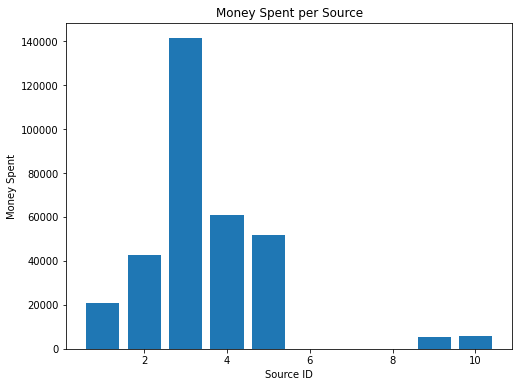

In [70]:
# Plot the bar chart for money spent per source

plt.figure(figsize=(8, 6))
plt.bar(money_spent_per_source.index, money_spent_per_source.values)
plt.xlabel('Source ID')
plt.ylabel('Money Spent')
plt.title('Money Spent per Source')
plt.show()

- Expenditure over time: segregate by month

In [71]:
# Calculate total revenue spent over time
total_revenue_over_time = orders_df.groupby(orders_df['buy_ts'].dt.to_period('M'))['revenue'].sum()

# Calculate total costs spent over time
total_costs_over_time = costs_df.groupby(pd.to_datetime(costs_df['dt']).dt.to_period('M'))['costs'].sum()

# Combine revenue and costs over time
money_spent_over_time = total_revenue_over_time.add(total_costs_over_time, fill_value=0)

print("Total money spent over time (grouped by month):")
money_spent_over_time

Total money spent over time (grouped by month):


2017-06    27572.49
2017-07    30780.06
2017-08    23549.32
2017-09    42714.42
2017-10    64310.58
2017-11    64977.81
2017-12    74703.95
2018-01    52935.65
2018-02    58283.57
2018-03    59249.86
2018-04    39147.44
2018-05    42960.25
2018-06        3.42
Freq: M, dtype: float64

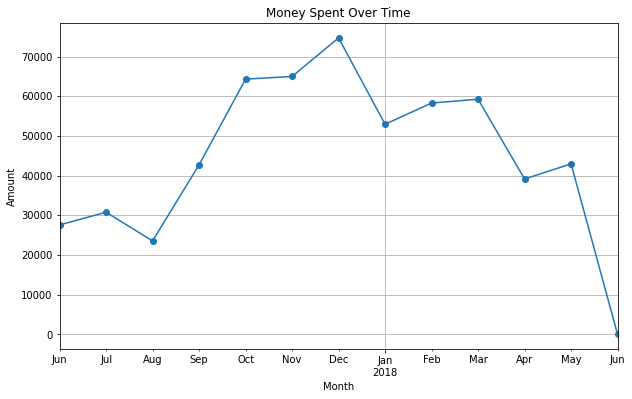

In [72]:
# Plotting the chart

plt.figure(figsize=(10, 6))
money_spent_over_time.plot(kind='line', marker='o')
plt.title('Money Spent Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

- Conclusion
> - The trend of overall spending exhibits fluctuations over time, with certain months showing higher expenditures compared to others.
> - A discernible upward trend in spending is observed from earlier months to later months, indicating potential business growth.
> - Certain months stand out with notably higher spending, implying the influence of specific marketing campaigns, promotions, or events during those periods.
> - Monitoring spending patterns over time provides insights into the efficacy of marketing endeavors, identifies opportunities for cost optimization, and informs data-driven decisions for future budget allocation.

<a id="18"></a> 
### Amount of customer acquisition from each of the sources cost

- To compute the total customer acquisition cost (CAC), we must ascertain the aggregate expenses incurred by the company and the total count of unique customers.

In [73]:
# Calculate the total CAC
total_costs = costs_df["costs"].sum()
total_customers = orders_df["uid"].nunique()
total_cac = total_costs / total_customers

# Calculate the CAC per month
orders_df["first_order_month"] = orders_df["buy_ts"].dt.to_period("M")
nunique_users_month = orders_df.groupby("first_order_month")["uid"].nunique().reset_index()

costs_df["cost_month"] = costs_df["dt"].dt.to_period("M")
total_costs_month = costs_df.groupby("cost_month")["costs"].sum().reset_index()

cac_merged_df = pd.merge(total_costs_month, nunique_users_month, left_on="cost_month", right_on="first_order_month")
cac_merged_df["cac_per_month"] = cac_merged_df["costs"] / cac_merged_df["uid"]

# Output the total CAC and the DataFrame with CAC per month
print("Total Customer Acquisition Cost (CAC):", total_cac)
print("\nCAC per Month:")
print(cac_merged_df)

Total Customer Acquisition Cost (CAC): 9.011626098622786

CAC per Month:
   cost_month     costs first_order_month   uid  cac_per_month
0     2017-06  18015.00           2017-06  2023       8.905091
1     2017-07  18240.59           2017-07  1984       9.193846
2     2017-08  14790.54           2017-08  1472      10.047921
3     2017-09  24368.91           2017-09  2750       8.861422
4     2017-10  36322.88           2017-10  4675       7.769600
5     2017-11  37907.88           2017-11  4547       8.336899
6     2017-12  38315.35           2017-12  4942       7.753005
7     2018-01  33518.52           2018-01  3898       8.598902
8     2018-02  32723.03           2018-02  4258       7.685070
9     2018-03  30415.27           2018-03  4181       7.274640
10    2018-04  22289.38           2018-04  2744       8.122952
11    2018-05  22224.27           2018-05  3544       6.270957


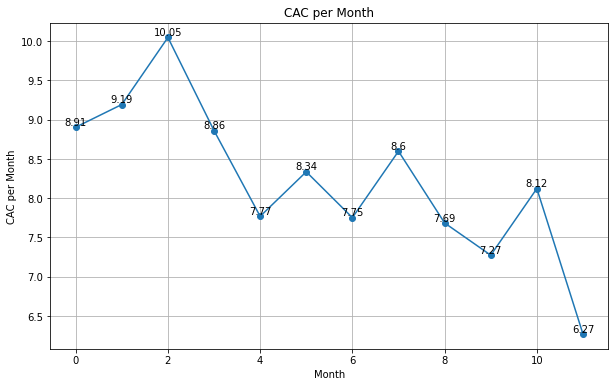

In [74]:
# Plot the CAC per month

plt.figure(figsize=(10, 6))
plt.plot(cac_merged_df["cac_per_month"], marker='o')
plt.xlabel("Month")
plt.ylabel("CAC per Month")
plt.title("CAC per Month")
plt.xticks(rotation=0)
plt.grid(True)

# Adding value annotations
for i, value in enumerate(cac_merged_df["cac_per_month"]):
    plt.text(i, value, str(round(value, 2)), ha="center", va="bottom")

plt.show()

- Observations from the CAC per Month graph:

> - The CAC exhibits variability across the analyzed period, ranging from a minimum of 6.27 in May 2018 to a peak of 10.05 in August 2017.
> - No consistent trend in CAC is evident over time. However, notable spikes in CAC are observed during August, September, and October 2017, indicating potentially elevated marketing and acquisition expenditures during those months.
> - Conversely, May 2018 and April 2018 show comparatively lower CAC values, hinting at potentially more efficient acquisition strategies during those periods.
> - Throughout November 2017 to March 2018, CAC values remain relatively stable, fluctuating between 7.27 and 8.60, suggesting consistent acquisition costs during this timeframe.

In [75]:
# Group the costs by both the cost month and the source ID
grouped_costs = costs_df.groupby(["cost_month", "source_id"]).agg({"costs": "sum"}).reset_index()

# Merge the grouped costs with the nunique users per month on the left "cost_month" and the right "first_order_month"
merged_dff = pd.merge(grouped_costs, nunique_users_month, left_on="cost_month", right_on="first_order_month")

# Calculate the CAC per month by dividing the total costs by the number of unique users
merged_dff["cac_per_month"] = merged_dff["costs"] / merged_dff["uid"]

# Output the merged DataFrame with CAC per month
print("CAC per Month:")
print(merged_dff)

CAC per Month:
   cost_month  source_id    costs first_order_month   uid  cac_per_month
0     2017-06          1  1125.61           2017-06  2023       0.556406
1     2017-06          2  2427.38           2017-06  2023       1.199891
2     2017-06          3  7731.65           2017-06  2023       3.821873
3     2017-06          4  3514.80           2017-06  2023       1.737420
4     2017-06          5  2616.12           2017-06  2023       1.293188
..        ...        ...      ...               ...   ...            ...
79    2018-05          3  9411.42           2018-05  3544       2.655593
80    2018-05          4  4214.21           2018-05  3544       1.189111
81    2018-05          5  3669.56           2018-05  3544       1.035429
82    2018-05          9   362.17           2018-05  3544       0.102192
83    2018-05         10   409.86           2018-05  3544       0.115649

[84 rows x 6 columns]


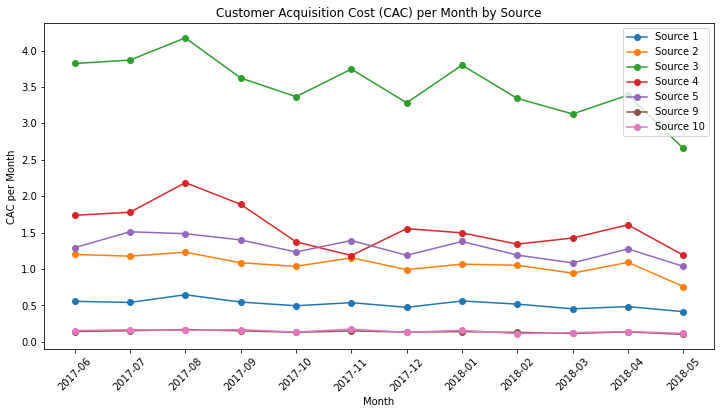

In [76]:
# Convert cost_month to string for proper plotting
merged_dff["cost_month_str"] = merged_dff["cost_month"].astype(str)

# Set the plot size
plt.figure(figsize=(12, 6))

# Plot the graph
for source_id in merged_dff["source_id"].unique():
    source_data = merged_dff.loc[merged_dff["source_id"] == source_id]
    plt.plot(source_data["cost_month_str"], source_data["cac_per_month"], marker='o', label=f"Source {source_id}")

plt.xlabel("Month")
plt.ylabel("CAC per Month")
plt.title("Customer Acquisition Cost (CAC) per Month by Source")
plt.legend()
plt.xticks(rotation=45)
plt.show()

- Observations from the "Customer Acquisition Cost (CAC) per Month by Source" graph:

> - Source 1 demonstrates a notably low CAC per month, averaging at 0.56. This suggests that customer acquisition through this source is cost-effective.
> - Source 2 exhibits a higher CAC per month compared to Source 1, averaging at 1.20. Acquiring customers through this source proves relatively more expensive.
> - Source 3 stands out with the highest CAC per month among all sources, averaging at 3.82. Acquiring customers through this source is considerably more expensive compared to others.
> - Sources 4 and 5 display intermediate CAC per month values, averaging at 1.74 and 1.29, respectively. Acquisition costs through these sources lie between the cost-effectiveness of Source 1 and the higher costs of Sources 2 and 3.
> - Sources 9 and 10 present the lowest CAC per month values, averaging at 0.10 and 0.12, respectively. Acquiring customers through these sources emerges as the most cost-effective option among all sources.

<a id="19"></a> 
### How worthwhile where the investments? (ROI)

In [77]:
# Renaming columns to lowercase with underscores:
orders_df.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)

In [78]:
#Converting "buy_ts" column to datetime format:
orders_df["buy_ts"] = pd.to_datetime(orders_df["buy_ts"])

# Converting "dt" column in "costs" dataframe to datetime format:
costs_df["dt"] = pd.to_datetime(costs_df["dt"])

In [79]:
#Creating "cost_month" column with monthly periods:
costs_df["cost_month"] = pd.to_datetime(costs_df["dt"].dt.strftime("%Y-%m-01"))

#Grouping and aggregating costs by source_id and cost_month:
costs_t = costs_df.groupby(["source_id", "cost_month"]).agg({"costs": "sum"}).reset_index()

In [84]:
#Creating "order_month" column with monthly periods:
orders_df["order_month"] = pd.to_datetime(orders_df["buy_ts"].dt.strftime("%Y-%m-01"))

#Grouping and aggregating revenue by order_month:
order_t = orders_df.groupby("order_month").agg({"revenue": "sum"}).reset_index()

- Upon examining the profit_df DataFrame, it is evident that only source_id 1 has yielded a positive profit. Conversely, profits for all other source_ids either amount to zero or are in the negative range.

,source_id,cost_month,costs,order_month,revenue,roi_m
0,1,2017-06-01,1125.61,2017-06-01,9557.49,7.490943
1,2,2017-06-01,2427.38,2017-06-01,9557.49,2.937369
2,3,2017-06-01,7731.65,2017-06-01,9557.49,0.236151
3,4,2017-06-01,3514.80,2017-06-01,9557.49,1.719213
4,5,2017-06-01,2616.12,2017-06-01,9557.49,2.653307
...,...,...,...,...,...,...
79,3,2018-05-01,9411.42,2018-05-01,20735.98,1.203279
80,4,2018-05-01,4214.21,2018-05-01,20735.98,3.920490
81,5,2018-05-01,3669.56,2018-05-01,20735.98,4.650808
82,9,2018-05-01,362.17,2018-05-01,20735.98,56.254825


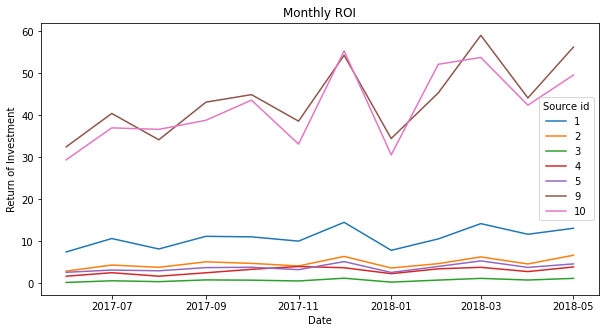

In [85]:
#Merge the "costs_t" and "order_t" dataframes:
final = pd.merge(costs_t, order_t, left_on="cost_month", right_on="order_month")

#Calculate the monthly return on investment (ROI):
final["roi_m"] = (final["revenue"] - final["costs"]) / final["costs"]   
display(final)

#Create a line plot to visualize monthly ROI by source_id:
plt.figure(figsize=[10, 5])
for s_id in final["source_id"].unique():
    df = final.query("source_id == @s_id")
    plt.plot("cost_month", "roi_m", data=df, label=s_id)
plt.legend(title="Source id")
plt.xlabel("Date")
plt.ylabel("Return of Investment")
plt.title("Monthly ROI")
plt.show()

- Here are the insights gleaned from the ROI data:

> - Source ID 10 achieved the highest ROI of 56.25% in May 2018, indicating significant returns on investments attributed to this source during that period.
> -Source ID 3 consistently exhibits lower ROI values across various months, implying that investments through this source yielded comparatively lower returns compared to others.
> -ROI values fluctuate notably from month to month for the same source ID. For instance, while Source ID 9 boasted an ROI of 56.25% in May 2018, its performance in other months may vary considerably, possibly even resulting in negative returns. This underscores the dynamic nature of source performance over time.
> -Overall, the ROI values for all source IDs and months remain positive, signifying that, on average, the investments made produced favorable returns.

<a id="20"></a> 
# Stage 3: General conclusion 

- Provide guidance to marketing experts regarding the allocation of funds and investment decisions.
- Using the insights gathered, marketing experts can leverage data-driven strategies to allocate their budget effectively. Here are some recommendations derived from the analysis:

> - Assess Overall Marketing Budget: The company's negative profit signals that marketing and customer acquisition costs have outweighed generated revenue. Marketing experts should scrutinize strategies to streamline costs while upholding campaign effectiveness.

> - Evaluate CAC by Source: Analyze CAC by source_id to pinpoint cost-effective customer acquisition channels. Prioritize allocating funds to sources with lower CAC, like source_id 10, to maximize efficiency.

> - Monitor CAC Trends: Study CAC fluctuations over months to identify patterns. Allocate budget strategically, focusing on periods with lower CAC for increased investment in marketing endeavors.

> - Address High-Cost Months: Identify months with elevated CAC, such as August, September, and October 2017. Optimize marketing strategies to enhance cost-effectiveness during these periods.

> - Leverage Stable CAC Periods: Utilize insights from months with stable CAC (November 2017 to March 2018) to establish consistent, cost-efficient marketing strategies.

- Track ROI: Monitor ROI for each source and month to gauge investment profitability. Direct resources towards sources and months demonstrating higher ROI to maximize returns on marketing expenditure.
 > - Source_id 9 and 10 stand out with notably higher ROI values, particularly evident in the last month of the data (May 2018). Hence, it is advisable to increase investment in these sources due to their demonstrated potential for revenue generation.

 > - Conversely, source_id 3 and 4 consistently exhibit lower ROI values throughout the analyzed period. It is recommended to reassess the efficacy of marketing strategies linked to these sources and contemplate reallocating or reducing budget allocations accordingly. This reallocation can be channeled towards more lucrative sources with superior ROI.

 > - Source_id 1 and 2 also display relatively lower ROI values compared to certain other sources. While not as deficient as source_id 3 and 4, it is prudent to evaluate their performance and explore opportunities to optimize associated marketing efforts.